In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [2]:
gaussian_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_Gaussian.csv')
res_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_resolution.csv')
classes = sorted(gaussian_df[gaussian_df['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
gaussian_df['Scale'] = gaussian_df['Scale']**2
res_df['Factor'] = 1/res_df['Factor']

def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Developmental MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [4]:
sc_param_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Developmental MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

sc_param_df

,dataset,method,metric,size,fitted_u_bar,fitted_I_max,u_bar_error,I_max_error
0,shendure,Geneformer,Developmental MI,100,116.021,0.802,24.386,0.036
1,shendure,Geneformer,Developmental MI,359,207.217,1.243,20.798,0.026
2,shendure,Geneformer,Developmental MI,1291,271.351,1.504,44.861,0.051
3,shendure,Geneformer,Developmental MI,4641,403.606,1.794,42.211,0.038
4,shendure,Geneformer,Developmental MI,16681,342.730,1.938,18.838,0.020
...,...,...,...,...,...,...,...,...
195,PBMC,SCVI,Protein MI,4641,1366.756,3.896,294.280,0.109
196,PBMC,SCVI,Protein MI,10000,3339.672,4.588,419.178,0.072
197,PBMC,SCVI,Protein MI,21544,6967.881,5.162,814.322,0.074
198,PBMC,SCVI,Protein MI,46415,5215.633,5.106,569.952,0.067


5


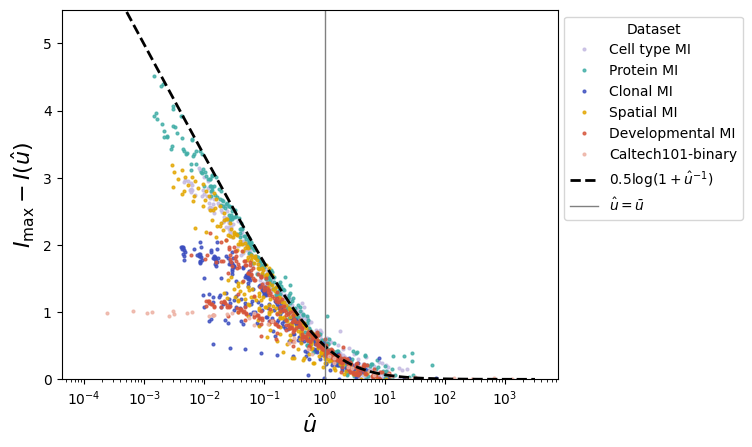

In [5]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

# plotting setup
fig, ax = plt.subplots()

c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette = c6 #[c6[c] for c in range(6) if c in [1,2,3,4]]

# params
lw, alpha, ms = 0, 0.8, 2
hue_order = ['PCA', 'SCVI', 'Geneformer']
signals = df['signal'].unique().tolist()
print(len(signals))

# iterate over signals
def fit_and_plot(df):
    for idx, sig in enumerate(signals):
        sub = df[df['signal'] == sig]
        for s in sub['size'].unique():
            part = sub[sub['size'] == s]
            for alg in hue_order:
                dat = part[part['algorithm'] == alg]
                dat = dat.groupby('umis_per_cell')[['umis_per_cell', 'mi_value']].mean()
                x = dat['umis_per_cell']
                y = dat['mi_value']

                if len(y) < 10:
                    continue

                # print(len(y), len(x))

                # # fit model
                # m = Model(info_scaling)
                # p = m.make_params(A=1e-1, B=1e-2)
                # p['A'].min = 0; p['B'].min = 0
                # res = m.fit(y, p, x=x)
                # # print(res.fit_report())

                # a, b = res.params['A'].value, res.params['B'].value
                # err_a, err_b = res.params['A'].stderr, res.params['B'].stderr

                # get params from sc_param_df
                row = sc_param_df[(sc_param_df['metric'] == sig) 
                                  & (sc_param_df['method'] == alg)
                                  & (sc_param_df['size'] == s)]
                if row.empty:
                    continue
                xbar = row['fitted_u_bar'].values[0]
                imax = row['fitted_I_max'].values[0]
                err_xbar = row['u_bar_error'].values[0]
                err_imax = row['I_max_error'].values[0]

                # check error
                if err_xbar and err_imax and err_xbar < xbar and err_imax < imax:
                    xhat = x / xbar
                    # plot residual info
                    ax.plot(
                        xhat,
                        imax - y,
                        color=c6[idx],
                        marker='o',
                        alpha=alpha,
                        markersize=ms,
                        label=sig,
                        lw=lw
                    )

fit_and_plot(df)



for im_idx, imdf in enumerate([gaussian_df, res_df]):

    for i, x in enumerate(classes[:-1]):
        # prepare data
        x_name = ['Scale', 'Factor'][im_idx]
        x_data = (1 / (imdf[imdf['Class label'] == x][x_name]))
        y_data = imdf[imdf['Class label'] == x]['MI']

        # create model and parameters
        model = Model(info_scaling)
        params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(y_data, params, x=x_data)

        if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

            if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
                

                x_bar = 1/result.params['A'].value

                x_hat = x_data / x_bar

                I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

                ax.plot(x_data / x_bar, I_max-y_data, color=c6[-1], marker='o',
                        alpha=alpha, markersize=ms, label='Caltech101-binary', lw=lw)



xs = np.logspace(-4, 3.5, 100)
ys = 0.5*np.log2(1 + 1/xs)
ax.plot(xs, ys, color='black', linestyle='--', alpha=1, lw=2,
         label=r'$0.5 \log (1 + \hat{u}^{-1})$')
ax.plot([1, 1], [0, 5.5], color='grey', linestyle='-', alpha=1, label=r'$\hat{u} = \bar{u}$', lw=1)


ax.set_xscale('log')
ax.set_ylabel(r'$I_{\max} - I(\hat{u})$',fontsize=16)
ax.set_xlabel(r'$\hat{u}$', fontsize=16)
ax.set_ylim(0, 5.5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1., 1.), title='Dataset')
plt.show()